In [1]:
# import module
import os
import glob
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm


# seed setting
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(1212)


D:\Anacoda\envs\Pytorch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset preparation
### Create dataset in Pytorch
We unify the inputed image information as following
- Resize image to 64 $\times$ 64
- Normalize the image

In [2]:
# prepare for MyDataset

class Mydataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        if self.transform:
            img = self.transform(img)
        return img
    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ]
    transform = transforms.Compose(compose)
    dataset = Mydataset(fnames, transform)
    return dataset

## Show images examples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


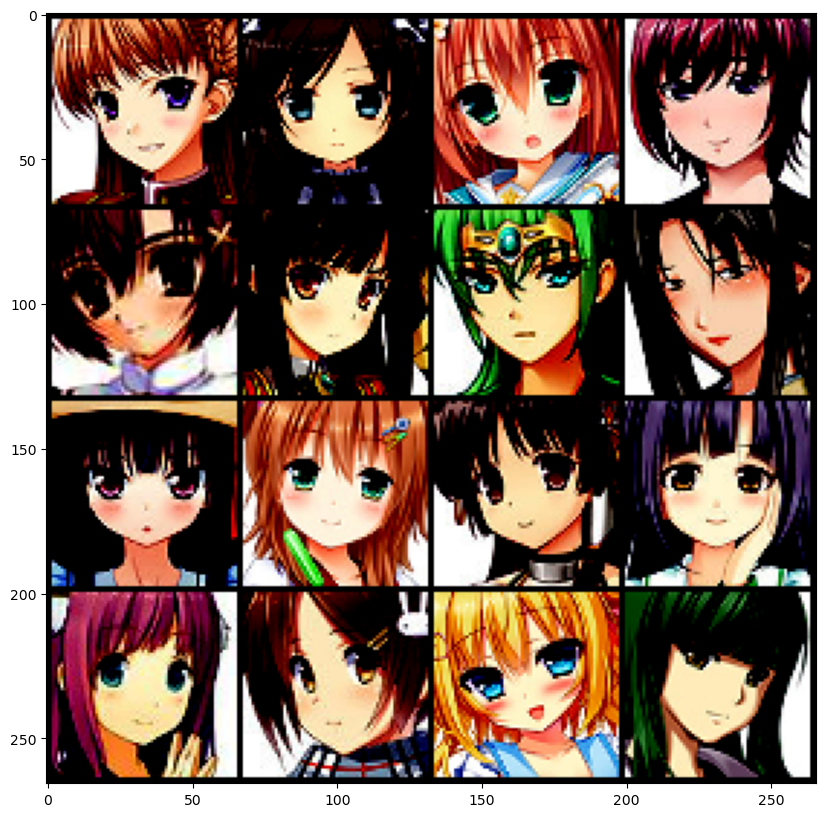

In [10]:
data_dir = 'D:\Datasets\Anime Faces'
temp_dataset = get_dataset(os.path.join(data_dir, 'face'))
img_examples = [temp_dataset[i] for i in np.random.randint(0, len(temp_dataset), 16)]
grid_img = torchvision.utils.make_grid(img_examples, nrow = 4)
fig = plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.savefig('examples.png')
plt.show()


# def show(imgs):
#     if not isinstance(imgs, list):
#         imgs = [imgs]
#     fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = img.detach()
#         img = torchvision.transforms.functional.to_pil_image(img)
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
# show(grid_img)

## Create the model
GAN includes two parts:
- generator
- discriminator

We start with creating the generator.

In [18]:
## Generator
class Generator(nn.Module):
    """
    Input shape: (batch, in_dim)
    Output shape: (batch, 3, 64, 64)
    """
    def __init__(self, in_dim = 100, out_dim = 64):
        super().__init__()
        
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, out_dim * 8 * 4 * 4, bias = False),
            nn.BatchNorm1d(out_dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2 = nn.Sequential(
            self.dconv_bn_relu(out_dim * 8, out_dim * 4),
            self.dconv_bn_relu(out_dim * 4, out_dim * 2),
            self.dconv_bn_relu(out_dim * 2, out_dim)
        )
        self.l3 = nn.Sequential(
            nn.ConvTranspose2d(out_dim, 3, kernel_size=5, stride=2,
                               padding = 2, output_padding=1, bias = False)
        )
        
        
    def dconv_bn_relu(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=5, stride=2,
                               padding = 2, output_padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2(y)
        y = self.l3(y)
        return y

In [19]:
generator = Generator().cuda()
torchsummary.summary(generator, input_size=(100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]         819,200
       BatchNorm1d-2                 [-1, 8192]          16,384
              ReLU-3                 [-1, 8192]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       3,276,800
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         819,200
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         204,800
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           4,800
Total params: 5,142,080
Trainable param

In [20]:
## Discriminator

class Discriminator(nn.Module):
    """
    Input shape: (batch, 3, 64, 64)
    Output shape: (batch)
    """
    
    def __init__(self, in_dim=64, feature_dim=64):
        super().__init__()
        
        self.l1 = nn.Sequential(
            nn.Conv2d(3, feature_dim, kernel_size=4, stride=2, padding=1), #(batch, feacture_dim, 32, 32)
            nn.LeakyReLU(0.2),
            self.conv_bn_lrelu(feature_dim, feature_dim*2), #(batch, feacture_dim * 2, 16, 16)
            self.conv_bn_lrelu(feature_dim*2, feature_dim*4), #(batch, feacture_dim * 4, 8, 8)
            self.conv_bn_lrelu(feature_dim*4, feature_dim*8), #(batch, feacture_dim * 8, 4, 4)
            nn.Conv2d(feature_dim*8, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )
        self.apply(self.__init_weights)
        
    def conv_bn_lrelu(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    ## Initialize weights
    def __init_weights(self, module):
        name = module.__class__.__name__
        if name.find('Conv') != -1:
            module.weight.data.normal_(0.0, 0.02)
        elif name.find('BatchNorm') != -1:
            module.weight.data.normal_(1.0, 0.02)
            module.bias.data.fill_(0)
            
    def forward(self, x):
        y = self.l1(x)
        y = y.view(-1)
        return y


In [21]:
discriminator = Discriminator().cuda()
torchsummary.summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,193
          Flatten-13                    [-1, 1]               0
          Sigmoid-14                   

## Create trainer

In this section, we will create a trainer which contains:
- perpare_env: repare the overall environment, construct the models, create directory for the log and ckpt
- train: train for generator and discriminator, you can try to modify the code here to construct WGAN or WGAN-GP
- inference: after training, you can pass the generator ckpt path into it and the function will save the result for you

In [57]:

class TrainerGAN():
    def __init__(self, config):
        
        """
        config:[
            'workspace_dir',
            'z_dim',
            'img_dir',
            'batch_size',
            'lr',
            'n_epoch',
            'n_critic'
        ]
        """
        
        self.config = config
        
        self.G = Generator()
        self.D = Discriminator()
        
        self.loss = nn.BCELoss()
        
        """
        NOTE FOR SETTING OPTIMIZER:

        GAN: use Adam optimizer
        WGAN: use RMSprop optimizer
        WGAN-GP: use Adam optimizer
        """
        self.opt_D = torch.optim.Adam(self.D.parameters(), lr=self.config['lr'], betas=(0.5, 0.999))
        self.opt_G = torch.optim.Adam(self.G.parameters(), lr=self.config['lr'], betas=(0.5, 0.999))
        
        self.dataloader = None
        self.log_dir = os.path.join(self.config['workspace_dir'], 'logs')
        self.ckpt_dir = os.path.join(self.config['workspace_dir'], 'ckpt')
        
        FORMAT = '%(asctime)s - %(levelname)s: %(message)s'
        logging.basicConfig(level=logging.INFO,
                            format=FORMAT,
                            datefmt='%Y-%m-%d %H:%M')
        
        self.steps = 0
        self.z_samples = torch.randn(100, self.config['z_dim']).cuda()
        
    def prepare_env(self):
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.ckpt_dir, exist_ok=True)
        
        # update dir by time
        time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        self.log_dir = os.path.join(self.log_dir, time + f'_{self.config["model_type"]}')
        self.ckpt_dir = os.path.join(self.ckpt_dir, time + f'_{self.config["model_type"]}')
        os.makedirs(self.log_dir)
        os.makedirs(self.ckpt_dir)
        
        # create dataset
        dataset = get_dataset(os.path.join(self.config['img_dir'], 'face'))
        self.dataloader = DataLoader(dataset, batch_size=self.config['batch_size'],
                                     shuffle=True)
        
        # model preparation
        
        #self.G.load_state_dict(torch.load(os.path.join(G_PATH, 'Anime Face Ge', 'ckpt',
        #               '2022-09-15_14-54-16_GAN','G_49.pth')))
        #self.D.load_state_dict(torch.load(os.path.join(G_PATH, 'Anime Face Ge', 'ckpt',
        #               '2022-09-15_14-54-16_GAN','D_49.pth')))
        
        self.G = self.G.cuda()
        self.D = self.D.cuda()
        self.G.train()
        self.D.train()
        
    def train(self):
        """
        Use this function to train generator and discriminator
        """
        self.prepare_env()
        for e, epoch in enumerate(range(self.config['n_epoch'])):
            progress_bar = tqdm(self.dataloader)
            progress_bar.set_description(f"Epoch {e+1}")
            for i, data in enumerate(progress_bar):
                imgs = data.cuda()
                bs = imgs.size(0)
                
                # *********************
                # *    Train D        *
                # *********************
                
                z = torch.randn(bs, self.config['z_dim']).cuda()
                r_imgs = torch.tensor(imgs).cuda()
                f_imgs = self.G(z)
                r_label = torch.ones(bs).cuda()
                f_label = torch.zeros(bs).cuda()
                
                # Discriminator forwarding
                r_logit = self.D(r_imgs)
                f_logit = self.D(f_imgs)
                
                """
                NOTE FOR SETTING DISCRIMINATOR LOSS:
                
                GAN: 
                    loss_D = (r_loss + f_loss)/2
                WGAN: 
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
                WGAN-GP: 
                    gradient_penalty = self.gp(r_imgs, f_imgs)
                    loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty
                """
                
                # Loss for Discriminator
                
                ## GAN
                r_loss = self.loss(r_logit, r_label)
                f_loss = self.loss(f_logit, f_label)
                loss_D = (r_loss + f_loss) / 2
                
                ## WGAN
                #loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
                
                
                # Discriminator backward
                self.opt_D.zero_grad()
                loss_D.backward()
                self.opt_D.step()
                
                """
                NOTE FOR SETTING WEIGHT CLIP:
                
                WGAN: below code
                """
                #for p in self.D.parameters():  
                #        p.data.clamp_(-self.config["clip_value"], self.config["clip_value"])
                                
                    
                # *********************
                # *    Train G        *
                # *********************
                if self.steps % self.config['n_critic'] == 0:
                    z = torch.randn(bs, self.config['z_dim']).cuda()
                    f_imgs = self.G(z)
                    f_logit = self.D(f_imgs)
                    
                    # GAN
                    loss_G = self.loss(f_logit, r_label)
                    
                    # WGAN
                    #loss_G = -torch.mean(self.D(f_imgs))
                    
                    """
                    NOTE FOR SETTING LOSS FOR GENERATOR:
                    
                    GAN: loss_G = self.loss(f_logit, r_label)
                    WGAN: loss_G = -torch.mean(self.D(f_imgs))
                    WGAN-GP: loss_G = -torch.mean(self.D(f_imgs))
                    """
                    self.opt_G.zero_grad()
                    loss_G.backward()
                    self.opt_G.step()
                    
                if self.steps % 10 == 0:
                    progress_bar.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())
                self.steps += 1
                
            self.G.eval()
            f_imgs_sample = (self.G(self.z_samples).data + 1) / 2.0
            filename = os.path.join(self.log_dir, f"Epoch_{epoch+1:03d}.jpg")
            torchvision.utils.save_image(f_imgs_sample, filename, nrow = 10)
            logging.info(f'Save some samples to {filename}')
            
            # Show some images during training
            grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
            plt.figure(figsize=(10,10))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.show()
            
            self.G.train()
            
            if (e + 1) % 5 == 0 or e == 0:
                # Save the checkpoint
                torch.save(self.G.state_dict(), os.path.join(self.ckpt_dir, f'G_{e}.pth'))
                torch.save(self.D.state_dict(), os.path.join(self.ckpt_dir, f'D_{e}.pth'))    
        logging.info('Finish training')
        
    def inference(self, G_path, n_generate=100, n_output=30, show=False):
        """
        1. G_path is the path for Generator ckpt
        2. Use this function to generate final answer
        """
        self.G.load_state_dict(torch.load(G_path))
        self.G.cuda()
        self.G.eval()
        z = torch.randn(n_generate, self.config['z_dim']).cuda()
        imgs = (self.G(z).data + 1) / 2.0
        
        os.makedirs('ouput', exist_ok=True)
        for i in range(n_generate):
            torchvision.utils.save_image(imgs[i], f'output/{i+1}.jpg')
        if show:
            row, col = n_output // 10 + 1, 10
            grid_img = torchvision.utils.make_grid(imgs[:n_output].cup(), nrow=row)
            plt.figure(figsize=(row, col))
            plt.imshow(grid_img.permute(1, 2, 0))
            plt.show()
        


## Train
we set the config and trainer, then use it to train generator and discriminator

In [58]:
workspace_dir = 'D:\Dropbox\Deep learning\Deep Learning Hongyi Li\Anime Face Ge'

config = {
    "model_type": "WGAN",
    "clip_value": 10,
    "batch_size": 64,
    "lr": 1e-4,
    "n_epoch": 100,
    "n_critic": 2,
    "z_dim": 100,
    "workspace_dir": workspace_dir, # define in the environment setting
    "img_dir": 'D:\Datasets\Anime Faces'
}

In [ ]:
trainer = TrainerGAN(config)
trainer.train()